In [31]:
from ngsolve.webgui import Draw

import numpy as np
import ngsolve as ng

motor_npz = np.load('../meshes/motor_pizza.npz', allow_pickle = True)

geoOCC = motor_npz['geoOCC'].tolist()
m = motor_npz['m']; m_new = m
j3 = motor_npz['j3']

geoOCCmesh = geoOCC.GenerateMesh()
mesh = ng.Mesh(geoOCCmesh)
# mesh.Refine()
# mesh.Refine()

# Draw(mesh)
# HCurl = ng.HCurl(mesh, order = 2, nograds = True, dirichlet = 'left|right')
# help(mesh)
help(HCurl.mesh)

Help on Mesh in module ngsolve.comp object:

class Mesh(pybind11_builtins.pybind11_object)
 |  NGSolve interface to the Netgen mesh. Provides access and functionality
 |  to use the mesh for finite element calculations.
 |  
 |  Parameters:
 |  
 |  mesh (netgen.Mesh): a mesh generated from Netgen
 |  
 |  Method resolution order:
 |      Mesh
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  BBBoundaries(...)
 |      BBBoundaries(self: ngsolve.comp.Mesh, pattern: str) -> ngsolve.comp.Region
 |      
 |      Return co dim 3 boundary mesh-region matching the given regex pattern
 |  
 |  BBoundaries(...)
 |      BBoundaries(self: ngsolve.comp.Mesh, pattern: str) -> ngsolve.comp.Region
 |      
 |      Return co dim 2 boundary mesh-region matching the given regex pattern
 |  
 |  Boundaries(...)
 |      Boundaries(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. Boundaries(self: ngsolve.comp.Mesh, pattern: str) -> ng

In [24]:
HCurl = ng.HCurl(mesh, order = 1, nograds = True, dirichlet = 'left|right')
HCurl.mesh.levels
# HCurl = ng.HCurl(mesh, order = 1, nograds = True)

u,v = HCurl.TnT()

K = ng.BilinearForm(HCurl)
# K += (ng.curl(u)*ng.curl(v)+1e-5*u*v)*ng.dx
K += (ng.curl(u)*ng.curl(v)+0*u*v)*ng.dx
K.Assemble()

f = ng.LinearForm(HCurl)
f += ng.InnerProduct(ng.CF(ng.x),ng.curl(v))*ng.dx
# f += ng.CF((1,1))*v*ng.dx
f.Assemble()

# rows,cols,vals = K.mat.COO()
# import scipy.sparse as sp
# ngK = sp.csr_matrix((vals,(rows,cols)))

# np.linalg.matrix_rank(ngK.A)
# print(ngK.shape)

In [14]:
# List all edges... this is still kinda slow but what can you do
i = 0
count = 0
edges = []
for edge in mesh.edges:
    index = HCurl.FreeDofs()[i]
    edge = [int(str(edge.vertices[0])[1:]), int(str(edge.vertices[1])[1:]), i]
    i = i + 1
    if index == 1:
        # Append only FreeDof edges.
        edges.append(edge)
    else:
        # Non-Freedof edges appended at start!
        edges.insert(0, edge)
        count = count + 1

edges = np.array(edges)
# print(HCurl.FreeDofs())
print(edges.shape,mesh.nedge,HCurl.ndof)
# edges[:200]
print(count)

import sys
sys.path.insert(0,'../../') # adds parent directory

import pde
MESH = pde.mesh.netgen(mesh.ngmesh)
print(MESH.NoEdges,MESH.nt,MESH.np)


# print(edges)
# edges[np.argwhere(edges==8360)[:,0],:]

(10028, 3) 10028 10028
56
10028 6664 3365


In [15]:
from mst5 import *
g = Graph(mesh.nv)
g.addEdges(edges)
mst = g.KruskalMST()

tree_indices = np.array(mst)[:,2]
print(tree_indices.size,mesh.nv)

3364 3365


In [16]:
import pyngcore as pyng
FreeDofsCotreeGauge = pyng.BitArray(HCurl.FreeDofs())
for i,j in enumerate(tree_indices): 
    # if FreeDofsCotreeGauge[j]==0:
    #     print('we have a problem',j)
    FreeDofsCotreeGauge.Clear(j)

print(mesh.ne,mesh.nv,mesh.nedge)

# print(HCurl.FreeDofs())
# 01010010010011101011111111111111111111111111111111
# 01100100110101101011100

uc = ng.GridFunction(HCurl, name="uc")
uc.vec[:] = 0
uc.vec[:1] = 10
# ng.SetVisualization(min=0, max=3)
Draw(uc, vectors={"grid_size":100})

# HCurl.ndof

# print()


6664 3365 10028


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [23]:
A = ng.GridFunction(HCurl)
A.vec.data = K.mat.Inverse(freedofs = FreeDofsCotreeGauge, inverse = 'sparsecholesky')*f.vec
# A.vec.data = K.mat.Inverse(HCurl.FreeDofs(), inverse = 'sparsecholesky')*f.vec

Draw(A, vectors={"grid_size":100})
Draw(ng.curl(A), mesh)
# A.vec.data.FV().NumPy().max()
# np.where(FreeDofsCotreeGauge)[0].shape

# ng.Integrate(ng.curl(A),mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

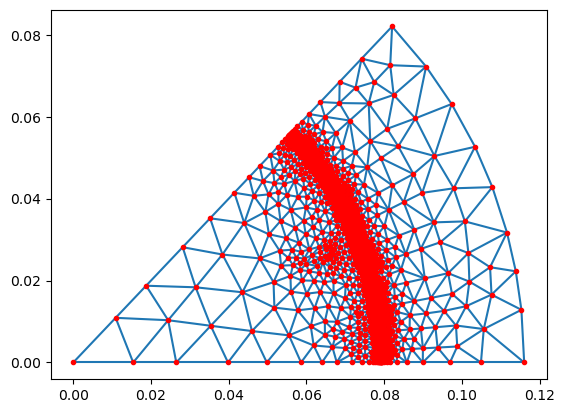

(10028, 3)

In [18]:
import numpy
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# %matplotlib qt

points = []
for vertex in mesh.vertices:
    points.append(list(vertex.point))
points = np.array(points)
nmst = np.array(mst)

# lc = LineCollection(points[nmst[:,:2]])
lc = LineCollection(points[edges[:10028,:2]])

fig = plt.figure()
plt.gca().add_collection(lc)
plt.plot(points[:,0], points[:,1], 'r.')

plt.show()

edges.shape

In [19]:
# # nmst = np.array(mst)
# print(nmst.shape,edges.shape)

# print(points.shape)

# nmst
# edges

In [20]:
points[1442]

array([0.09076188, 0.07223767])

In [21]:
nmst[:6]

array([[1450, 1451, 5227],
       [1449, 1450, 5224],
       [1448, 1449, 5221],
       [1447, 1448, 5218],
       [1446, 1447, 5216],
       [1445, 1446, 5215]])

In [22]:
print(HCurl.ndof,HCurl.ndofglobal,np.array(HCurl.FreeDofs()).shape,mesh.nedge, mesh.nv, mesh.ne, edges.shape)
# print(HCurl.FreeDofs())
# edges[:200,:]

10028 10028 (10028,) 10028 3365 6664 (10028, 3)
